## Project Overview 

This project aims to create two machine learning classifiers that predicts the genre of a song after inputting lyrics as well as by using the audio qualities. This project will use datasets from Kaggle and data scraped from genius.com.

Problem statement: Can we build a model that uses various lyrics and audio attributes to accurately predict the genre of a song?

Prompt: You are working on a team that's developing an app that takes song lyrics and audio attributes to predict the song name and artist. It is your responsibility to model the portion of the Machine Learning app that takes in song lyrics and predicts the possible genre the lyrics are in.


This notebook will explore and clean our audio quality data. We will look at how these features affect the outcome of our genre classifications. 

## Data Exploration and EDA

We will begin by reading in and cleaning up our 'tracks' and 'genre' datasets.

In [43]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
import itertools
import string
import pickle
%matplotlib inline


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from numpy import mean
from numpy import std

In [50]:
tracks = pd.read_csv('./Data/data.csv')
genre = pd.read_csv('./Data/data_w_genres.csv')

In [51]:
tracks.head(1)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920


In [21]:
genre.head(1)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.5985,0.4701,267072.0,0.376203,0.010261,0.28305,-14.4343,0.20915,114.1288,0.35832,38.2,5,1,10,['show tunes']


The cleaning starts here.

In [31]:
#I want to clean the artists column to make them into strings
def track_strip(dataframe):
    
    dataframe['artists'] = dataframe['artists'].str.strip('[]') #stripping off brackets and and any extra quotations.
    dataframe['artists'] = dataframe['artists'].str.strip("''")
    dataframe['artists'] = dataframe['artists'].str.strip('""')
    print(dataframe.head(3))

In [32]:
track_strip(tracks)

   acousticness                artists  danceability  duration_ms  energy  \
0         0.991            Mamie Smith         0.598       168333   0.224   
1         0.643  Screamin' Jay Hawkins         0.852       150200   0.517   
2         0.993            Mamie Smith         0.647       163827   0.186   

   explicit                      id  instrumentalness  key  liveness  \
0         0  0cS0A1fUEUd1EW3FcF8AEI          0.000522    5    0.3790   
1         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
2         0  11m7laMUgmOKqI3oYzuhne          0.000018    0    0.5190   

   loudness  mode                      name  popularity release_date  \
0   -12.628     0  Keep A Song In Your Soul          12         1920   
1    -7.261     0      I Put A Spell On You           7   1920-01-05   
2   -12.098     1              Golfing Papa           4         1920   

   speechiness    tempo  valence  year  
0       0.0936  149.976    0.634  1920  
1       0.0534   86.889    0.95

In [232]:
track_strip(genre)

                                      artists  acousticness  danceability  \
0             Cats" 1981 Original London Cast      0.598500      0.470100   
1                    Cats" 1983 Broadway Cast      0.862538      0.441731   
2  Fiddler On The Roof” Motion Picture Chorus      0.856571      0.348286   

   duration_ms    energy  instrumentalness  liveness   loudness  speechiness  \
0     267072.0  0.376203          0.010261  0.283050 -14.434300     0.209150   
1     287280.0  0.406808          0.081158  0.315215 -10.690000     0.176212   
2     328920.0  0.286571          0.024593  0.325786 -15.230714     0.118514   

        tempo   valence  popularity  key  mode  count          genres  
0  114.128800  0.358320   38.200000    5     1     10  ['show tunes']  
1  103.044154  0.268865   31.538462    5     1     26              []  
2   77.375857  0.354857   34.571429    0     1      7              []  


In [33]:
#Will be dropping features I don't need. These are the id, year, and release_date columns.
tracks = tracks.drop(['id', 'release_date', 'year'], axis=1)
tracks.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence
0,0.991,Mamie Smith,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634
1,0.643,Screamin' Jay Hawkins,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,0.0534,86.889,0.950
2,0.993,Mamie Smith,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689


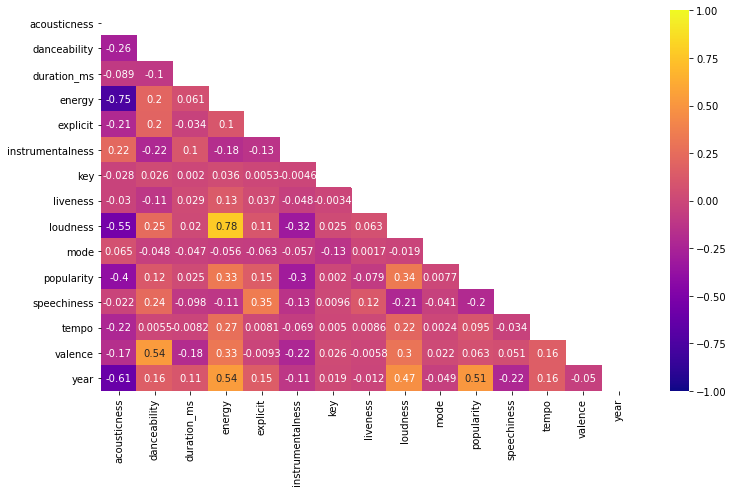

In [54]:
#I want to look at the correlation among the features, so I will be using a heatmap plot. This will help me group certain features together to identify 
#What affects genre categorization.
fig, ax = plt.subplots(figsize = (12, 7))

correlations = tracks.corr()
corr_2 = np.triu(correlations)
ax = sns.heatmap(correlations, 
    vmin=-1, vmax=1, center=0,
    cmap='plasma',
   annot=True, mask=corr_2) # using the upper triangle matrix as mask 




There are strong correlations between energy & loudness, danceability & valence, explicit & speechiness, popularity and loudness, along with energy and popularity.

### EDA for Genres Dataset


I will do some cleaning on the genre dataset, since I want to map the genres to the artists in tracks.

In [214]:
genre['genres'] = genre['genres'].str.strip('[]') #stripping off brackets and and any extra quotations.
genre['genres'] = genre['genres'].str.strip("''")
genre['genres'] = genre['genres'].str.strip('""')
genre.head(3)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"Cats"" 1981 Original London Cast",0.598500,0.470100,267072.0,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,show tunes
1,"Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.0,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,
2,Fiddler On The Roof” Motion Picture Chorus,0.856571,0.348286,328920.0,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,


In [17]:
genre.shape

(32539, 16)

In [215]:
#This dictionary will be used to map the genres of the artists to the 'tracks' dataframe.

genres_dict = pd.Series(genre['genres'].values,index=genre['artists']).to_dict()
#genres_dict

In [234]:
#to merge the genres with the artists in the tracks column, I am mapping the above dictionary to the artist names into
#a new column in tracks. I am doing this so that I can see everything in one dataframe.
tracks['genre'] = tracks['artists'].map(genres_dict)

tracks.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,genre
0,0.991000,Mamie Smith,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.6340,"harlem renaissance', 'traditional blues"
1,0.643000,Screamin' Jay Hawkins,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,0.0534,86.889,0.9500,"blues', 'traditional blues"
2,0.993000,Mamie Smith,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,0.1740,97.600,0.6890,"harlem renaissance', 'traditional blues"
3,0.000173,Oscar Velazquez,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,0.0425,127.997,0.0422,circuit
4,0.295000,Mixe,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,0.0768,122.076,0.2990,glitchcore


In [236]:
#I want to view how many missing values there are so that I can remove those values if the number is not too large.
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   instrumentalness  174389 non-null  float64
 7   key               174389 non-null  int64  
 8   liveness          174389 non-null  float64
 9   loudness          174389 non-null  float64
 10  mode              174389 non-null  int64  
 11  name              174389 non-null  object 
 12  popularity        174389 non-null  int64  
 13  speechiness       174389 non-null  float64
 14  tempo             174389 non-null  float64
 15  valence           174389 non-null  float64
 16  genre             13

In [22]:
#genre has roughly 35K missing values. After viewing some of the missing values, I've decided I am going to drop them.
tracks = tracks.dropna()
audio_feats = tracks

In [116]:
#Now I will need to map the genres to more clear lables. Currently the genres are jumbled and have a lot of repetition
#To see how many unique genre values there are, I will print the number.
print("list of genres:", len(audio_feats.genre.unique()))

["harlem renaissance', 'traditional blues" "blues', 'traditional blues"
 'circuit' ... 'minimal dub' 'trap latino' "city pop', 'japanese r&b"]
list of genres: 8602


We have 8602 genre values! That is a lot. We will work on narrowing them down to 10.

Since I want to narrow down the amount of genres in the dataset, I will create a function that searches for a specific string value in my list of genres (gen_category), in each row of the dataframe. The function will then append the count of the genre-strings to a dictionary, and whichever genre has the most counts will be the populated genre in the new column.

In [239]:
def genre_category(string):
    captured_genres = []   #This list holds the genres captured from the inputs that are present in gen_category.
    gen_category = ['pop', 'hip hop', 'country', 'jazz', 'classical', 'latin', 'rock', 'metal', 'blues', 'house']
    count = {}    #Holds the count of each genre from gen_category present in the string.
    
    for category in gen_category:
        count[category] = 0    #Each count starts at 0.
    for gen in string.split(','): 
        for genre_name in gen_category:
            if genre_name in gen: #If the genre is in gen_category, then the count increases and the names are appended.
                count[genre_name]= count[genre_name] + 1 
                captured_genres.append(genre_name)
    max_value = max(count.items(), key=lambda x : x[1]) #This is our max value from our dictionary.
    if max_value[1] == 0:  #If the value of the genre is 0, then it was not found in our list of genres.
        return 'other'     #We will categorize these as 'other', since the genre is niche.
    else:
        return max_value[0]
                

In [240]:
audio_feats['new_genres'] = audio_feats['genre'].map(genre_category) #Applying the function to the column.

In [242]:
#Our function has been applied and now we have new genres. We will drop the old column.
audio_feats = audio_feats.drop('genre', axis=1)

In [243]:
audio_feats.head(2)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,new_genres
0,0.991,Mamie Smith,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,blues
1,0.643,Screamin' Jay Hawkins,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,0.0534,86.889,0.950,blues


In [244]:
audio_feats.to_csv('./data/audio_feats.csv')

To better understand how my genres stack up against each other, I will be looking at the variance between them. *Variance* measures the spread of data in a set from it's median and mean value.

I will group the audio qualities by the genre and find the mean for each one. 

In [2]:
audio_feats = audio_feats.drop('Unnamed: 0', axis=1)

In [4]:
#Code adapted from https://github.com/christianlomboy
variance_qualities = audio_feats.groupby(['new_genres']).mean()
variance_qualities

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
new_genres,,,,,,,,,,,,,,
blues,0.684709,0.590208,194491.977917,0.398959,0.002208,0.096798,5.191388,0.186194,-11.786620,0.796835,20.527788,0.075559,117.135032,0.651527
classical,0.784256,0.442558,226079.650397,0.306503,0.002270,0.413769,5.003405,0.190990,-15.823582,0.690125,17.007946,0.083524,111.486692,0.412891
country,0.466262,0.586341,197564.073163,0.496706,0.011536,0.027683,5.363540,0.193918,-10.589107,0.920613,35.077110,0.050055,119.461785,0.594094
hip hop,0.175897,0.725720,240405.670321,0.655412,0.627021,0.047239,5.608112,0.218807,-8.222480,0.570019,47.351329,0.211956,115.037738,0.580553
house,0.052617,0.599434,279697.382528,0.808813,0.010178,0.577947,5.749788,0.239308,-8.033364,0.490246,16.946565,0.075558,128.516789,0.428705
jazz,0.735635,0.518364,257089.553633,0.337979,0.000940,0.298659,5.035468,0.196468,-14.059969,0.624569,21.583229,0.059886,112.879686,0.498419
latin,0.351974,0.630162,242254.806285,0.611181,0.047353,0.020207,5.090831,0.197117,-8.554668,0.661644,42.965131,0.061833,121.939142,0.623957
metal,0.038703,0.419516,261237.802545,0.859639,0.218545,0.166391,5.444000,0.224949,-6.320803,0.615636,41.913455,0.088903,125.312712,0.364232
other,0.552126,0.561066,212435.067096,0.437396,0.085635,0.243583,5.234153,0.210931,-12.460915,0.692557,16.019318,0.164715,115.831169,0.550546


To better interpret our feature values, I will normalize the data so it is on a scale from 0-1.

In [5]:
#Code adapted from https://github.com/christianlomboy
normalize = variance_qualities.apply(lambda x: (x - x.min())/(x.max() - x.min()), axis=0)
normalize

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
new_genres,,,,,,,,,,,,,,
blues,0.866479,0.557447,0.000000,0.167150,0.002027,0.137323,0.251858,0.000000,0.424819,0.712389,0.143893,0.157532,0.331668,1.000000
classical,1.000000,0.075248,0.370724,0.000000,0.002125,0.705637,0.000000,0.090288,0.000000,0.464438,0.031553,0.206725,0.000000,0.169369
country,0.573479,0.544817,0.036055,0.343863,0.016925,0.013403,0.482507,0.145425,0.550836,1.000000,0.608253,0.000000,0.468294,0.800091
hip hop,0.184016,1.000000,0.538859,0.630784,1.000000,0.048467,0.810183,0.614018,0.799882,0.185361,1.000000,1.000000,0.208516,0.752957
house,0.018662,0.587577,1.000000,0.908114,0.014756,1.000000,1.000000,1.000000,0.819783,0.000000,0.029594,0.157524,1.000000,0.224414
jazz,0.934785,0.322818,0.734667,0.056904,0.000000,0.499250,0.042958,0.193439,0.185589,0.312113,0.177579,0.060724,0.081796,0.467071
latin,0.420186,0.687929,0.560561,0.550819,0.074133,0.000000,0.117132,0.205658,0.764925,0.398261,0.860009,0.072753,0.613763,0.904036
metal,0.000000,0.000000,0.783352,1.000000,0.347568,0.262100,0.590307,0.729645,1.000000,0.291357,0.826443,0.239952,0.811858,0.000000
other,0.688647,0.462272,0.210586,0.236637,0.135278,0.400501,0.309155,0.465729,0.353861,0.470090,0.000000,0.708208,0.255106,0.648512


From above, we can gauge a few things. Firstly, we see that *hip hop* has a high level of *speechiness*, as well as *danceability*, *popularity* and *explicitness*. These things are typically common in hip hop songs. 

*House* music has high levels in *instrumentalness, key, liveness and tempo*.

*Metal* music has high energy and loudness, which is consistent with the qualities of this genre. We can infer that all genres have attribute levels specfic to them.

# Modeling

For my baseline model, I will be using Decision Tree Classifiying to help in informing me of which columns play a part in classifying my data. I am choosing this because a decision tree model does not require scaling and the model is generally extremely intuitive. I will also use the bagging method to help in creating an ensemble of multiple models that will combine to build an overall model. Based on these results, I will explore other modeling methods and hyperparameters. I will be setting my n_estimators to 100. 

In [6]:
#Defining my features and standardizing
X = audio_feats.drop(['artists', 'new_genres', 'name'], axis=1)

#define our y
le = LabelEncoder()
y = le.fit_transform(audio_feats['new_genres'])

#train test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)



In [89]:
#A portion of this code was adapted from https://www.datatechnotes.com/

dc = DecisionTreeClassifier(criterion="entropy", max_depth=7)
bag = BaggingClassifier(base_estimator=dc, n_estimators=100, max_samples=0.8, bootstrap=True)
bag = bag.fit(X_train, y_train)

These are the predictions and accuracy of our baseline model. This score is at 51%, but it is not overfit. It is very low though, so we will try other classifiers.

In [90]:
#These are the predictions and accuracy of our baseline model. 
#This score is at 51%, but it is not overfit. It is very low though, so We will try other classifiers

print(f'Testing Accuracy {bag.score(X_test, y_test)}')
print(f'Training Accuracy {bag.score(X_train, y_train)}')

Testing Accuracy 0.5125518445754202
Training Accuracy 0.522962577962578


Our model is testing quite poorly, though we've eliminated our overfitting. In order to combat this, I will be revisiting my data and combining the lowest 4 classes. With our scores being so low, we can gauge that it is our features that are causing the low output.

From the steps below, we know we have 4 values that classify as minority classes. These values are classical, blues, latin and house. We deem them minorities because they have less than .02 weight each. Below, we will combine these classes to pick up more signal during our modeling. It is important to note that these 4 genres are "main genre categories". That is why they were not grouped into the "others" class. The "others" class consists of multiple niche genres, and to keep them separate, this distinction needs to be apparent.

In [8]:
audio_feats['new_genres'] = audio_feats['new_genres'].replace(['house','latin', 'classical', 'blues'],'house/latin/classical/blues')

pd.Series(audio_feats['new_genres']).value_counts(normalize=True) #Here is where we can see the unbalanced classses.

other                          0.345407
rock                           0.247335
pop                            0.168160
jazz                           0.092935
house/latin/classical/blues    0.051663
country                        0.047937
hip hop                        0.026552
metal                          0.020010
Name: new_genres, dtype: float64

## Modeling To Improve Score

Below, we will be trying an array of methods to improve our training and testing score, while keeping overfitting low.

In [94]:
#Decision tree model without bagging.
dc = DecisionTreeClassifier(criterion="gini", max_depth=7, random_state=42) #A max depth of 7 seems to provide us with the highest score and the least overfitting.
dc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [95]:
dc_preds = dc.predict(X_test)

In [96]:
print(f'Testing Accuracy {dc.score(X_test, y_test)}')
print(f'Training Accuracy {dc.score(X_train, y_train)}')

Testing Accuracy 0.5067549540372068
Training Accuracy 0.515914760914761


There is a tiny amount of overfit, but it isn't too noticeable. The score is extremely low here even still... We will adjust further hyper parameters and models to see if we can raise the score.


#### Random Forest Model with Cross-validation

I will now switch to using a random forest classifier. I want to stay on trend and because Random Forests are bagged decision trees, I am essentially still utilizing the decision tree model method, except, the random forest will split on a randomized subset of features.

In [36]:
sc = StandardScaler() #Scaled the data to see if this helps our model.
X_train_sc = sc.fit_transform(X_train) #Fit and transformed the X_train data
X_test_sc = sc.transform(X_test) 

In [56]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)
cvs = cross_val_score(estimator=rf, X=X_train_sc, y=y_train, cv=5)

In [55]:
print(f'Training Accuracy {cvs.mean()}') 
print(f'Standard Dev {cvs.std()}') #Our standard dev is very low, which is an indication that our model isn't doing so well.

Training Accuracy 0.5954677754677754
Standard Dev 0.002610037866523898


Our random forest score is better than our decision tree score reaching 59% but it is still low. Lets see if we can increase it to above 60%

In [98]:
#Modeling random forest without cross validation and on unscaled data
rfc = RandomForestClassifier(n_estimators=400, random_state=42, max_depth=7) #A max depth of 7 seems to rovide us with the highest score and the least overfitting.
rfc.fit(X_train_sc, y_train)

print(f'Testing Accuracy {rfc.score(X_test_sc, y_test)}')
print(f'Training Accuracy {rfc.score(X_train_sc, y_train)}') #We have a slight improvment from our baseline score here

Testing Accuracy 0.5146135002061656
Training Accuracy 0.5207276507276507


## Modeling with Additional Features Removed - GridSearch

Below, I will perform a train test split with the removal of more features that do not impact our data as much. These features were chosen, based on the relationships in our correlation plot from our EDA. The additonal removed features are: key, liveness and mode.

I will also be adding a Grid Search component. I am choosing to do this so that I can produce the optimum values using my hyperparameters. I am expecting this to increase my scores. 


In [13]:
#Defining my features and standardizing. "ft" denotes the newly made X, y with more features removed
X_ft = audio_feats.drop(['artists', 'new_genres', 'name', 'key', 'liveness', 'mode'], axis=1)

#define our y and encode it.
le = LabelEncoder()
y_ft = le.fit_transform(audio_feats['new_genres'])

#train test split of the data
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_ft, y_ft, test_size=.3, stratify=y, random_state=42)



In [27]:
#Creating a dictionary to map the genres to their encoded elements

gen_dict = {'other': 0,
           'rock' : 1,
            'pop' : 2,
            'jazz' : 3,
            'house/latin/classical/blues' : 4,
            'country' : 5,
            'hip hop' : 6,
            'metal' : 7
            }

In [14]:
rf= RandomForestClassifier()

#setting params
params = {
    'n_estimators' : [100, 120], #Keeping on trend with our n_estimators
    'max_depth' : [1,7,10,15], 
    'min_samples_split' : [2, 3],
    'min_samples_leaf' : [3, 5],
    'class_weight' : [{0: 1, 1: 1}, {0: 1, 1: 5}, {0:1, 1:1}] #Using the scikit-learn suggested weights
    
}

#Now we will use grid search to see what scores we achieve here...

rf_gs = GridSearchCV(rf, param_grid=params, cv= 5)
rf_gs.fit(X_train_ft, y_train_ft);

In [18]:
print('Random Forest Train score', rf_gs.score(X_train_ft, y_train_ft))
print('Random Forest Test score', rf_gs.score(X_test_ft, y_test_ft))

Random Forest Train score 0.7058939708939709
Random Forest Test score 0.5728977176259429


In [25]:
pred = rf_gs.predict(X_test_ft)

In [23]:
rf_gs.best_estimator_ #This is the best estimator based on this gridsearch for Random Forest.

RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=15,
                       min_samples_leaf=3)

In [17]:
#Saving our model so we don't need to rerun it next time.

rf_grid_mod = 'rf_model.sav'
pickle.dump(rf_gs, open(rf_grid_mod, 'wb'))

After running our random forest pipeline using GridSearch, we have achieved a higher training score, however, our testing score is still very low and there is evidence of much overfitting going on. Our test score is almost 13% lower than our train score. Generally, gridsearch is efficient in helping us find better scores. This final model leads me to believe that it is indeed our genre classification methods and our features that affected the scores.

In [26]:
print(classification_report(y_test_ft, pred))

              precision    recall  f1-score   support

           0       0.60      0.07      0.13      1976
           1       0.65      0.61      0.63      1095
           2       0.71      0.06      0.11      2130
           3       0.59      0.48      0.53      3832
           4       0.68      0.30      0.42       825
           5       0.65      0.74      0.69     14241
           6       0.47      0.30      0.37      6933
           7       0.51      0.77      0.62     10197

    accuracy                           0.57     41229
   macro avg       0.61      0.42      0.44     41229
weighted avg       0.58      0.57      0.54     41229



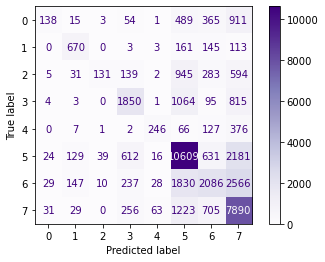

In [24]:
class_names = audio_feats['new_genres'] #Random Forest Grid Search - confusion matrix.
plot_confusion_matrix(rf_gs, X_test_ft, y_test_ft, cmap='Purples');

# Conclusions and Analysis

Our best model for our genre classification using audio attributes ended up being the Random Forest Classifier. Our final train score was at 70% while our test score was at 57%. Our best model was still overfit by 13%, and though we tried an array of different methods and hyperparameter tuning to increase our score, there was little to no improvment.
In reviewing our classification report, the precision of our model's predictions are generally higher than our recall outside of values 5 and 7 (metal and country). Our recall for 'other' (0), is very bad, almost at 0. This means our model didn't score right at all when it came to classifying that genre and we virtually got 0 songs correct. Our F1 scores are also low, which means our classifier did not output good results.

In reviewing our EDA elements we can see that our features were what largely impacted the models performance. Even after adjusting hyperparameters, our model's score was still relatively the same. To combat this, I adjusted the features further, but the results still came out similarly.

## Recommendations and Next Steps

The next steps for our audio classifier would be to revisit our features and genre classes and how they were classified. The classification system used can be improved by exploring the audio quality levels themselves and classifiying the songs by these levels. Largely, what we would need to improve is how we explore our features and the methods used to feed into the model.